<a href="https://colab.research.google.com/github/srujayreddyv/CSC219-P2-TimeSeriesForecastingusingLSTMandCNN/blob/main/CSC219TeamProject2_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJECT 2:  Time Series Forecasting using LSTM and CNN for Regression
### Team Challengers:
### 1. Alekya Paladugu
### 2. Samah Eltayeb
### 3. Srujay Reddy



# UPLOADING DATASET

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving energydataset.csv to energydataset.csv


# IMPORTS

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import collections
from scipy.stats import zscore
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
import os
%matplotlib inline
import datetime

from sklearn.metrics import roc_curve, auc#
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from matplotlib.pyplot import figure, show


from sklearn import metrics
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation,Bidirectional
from keras.callbacks import EarlyStopping # to prevent overfitting
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint


from keras import optimizers
%load_ext tensorboard



In [ ]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32, np.object):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


# READING THE DATASET  

In [ ]:
Dataset_CSV = 'energydataset.csv'

df= pd.read_csv(Dataset_CSV, delimiter =",", na_values=['NA','?'])
df[0:5]

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,1/11/2016 17:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,1/11/2016 17:10,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,1/11/2016 17:20,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,1/11/2016 17:30,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
4,1/11/2016 17:40,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
df.shape

(4484, 29)

# DATA PREPROCESSING

### CHECK FOR NULL VALUES


In [ ]:
df.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

### CHECK FOR DUPLICATE VALUES

In [ ]:
df.duplicated().any()

False

### DROPPING DATE AND Y


In [ ]:
x=df.drop(["date"],axis=1)
y=df.Appliances

In [ ]:
x

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,...,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


#Important features

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: Press_mm_hg, Score: 0.03178
Feature: RH_6, Score: 0.00557
Feature: RH_out, Score: 0.00368
Feature: RH_2, Score: 0.00293
Feature: RH_4, Score: 0.00213
Feature: RH_1, Score: 0.00205
Feature: RH_7, Score: 0.00191
Feature: RH_9, Score: 0.00188
Feature: RH_8, Score: 0.00186
Feature: RH_3, Score: 0.00151
Feature: RH_5, Score: 0.00029
Feature: T9, Score: 0.00002
Feature: T7, Score: 0.00001
Feature: Tdewpoint, Score: -0.00007
Feature: T_out, Score: -0.00010
Feature: T3, Score: -0.00023
Feature: T6, Score: -0.00023
Feature: T5, Score: -0.00027
Feature: rv1, Score: -0.00034
Feature: rv2, Score: -0.00034
Feature: T4, Score: -0.00040
Feature: T1, Score: -0.00064
Feature: Visibility, Score: -0.00076
Feature: T2, Score: -0.00077
Feature: Windspeed, Score: -0.00079
Feature: T8, Score: -0.00081
Feature: lights, Score: -0.00488
Feature: Appliances, Score: -0.06547


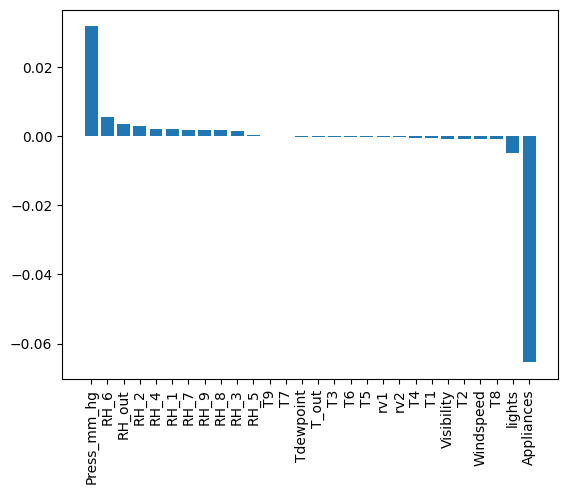

In [ ]:

from matplotlib import pyplot
# define the model
model = LogisticRegression()
# fit the model
model.fit(x, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
feature_imp = {}
for imp, col in zip(model.coef_[0], x.columns):
  feature_imp[col] = imp
  # print('Feature: {}, Score: {:.5f}'.format(col,imp))

feature_imp_sorted = dict(sorted(feature_imp.items(), key=lambda item: item[1], reverse=True))
for key, value in feature_imp_sorted.items():
  print('Feature: {}, Score: {:.5f}'.format(key,value))
# for i,v in enumerate(importance):
#  print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in feature_imp_sorted], feature_imp_sorted.values())
pyplot.xticks(rotation=90)
pyplot.show()

In [ ]:
x=x.drop(["Visibility","Windspeed","Tdewpoint","RH_5","T_out","T5","T3","T2","T9","lights","T1","T6","T7","T4","T8","rv1","rv2","Press_mm_hg"],axis=1)


In [ ]:
x

,Appliances,RH_1,RH_2,RH_3,RH_4,RH_6,RH_7,RH_8,RH_9,RH_out
0,60,47.596667,44.790000,44.730000,45.566667,84.256667,41.626667,48.900000,45.530000,92.000000
1,60,46.693333,44.722500,44.790000,45.992500,84.063333,41.560000,48.863333,45.560000,92.000000
2,50,46.300000,44.626667,44.933333,45.890000,83.156667,41.433333,48.730000,45.500000,92.000000
3,50,46.066667,44.590000,45.000000,45.723333,83.423333,41.290000,48.590000,45.400000,92.000000
4,60,46.333333,44.530000,45.000000,45.530000,84.893333,41.230000,48.590000,45.400000,92.000000
...,...,...,...,...,...,...,...,...,...,...
4479,130,46.230000,42.163333,45.826667,47.663333,90.090000,42.439444,44.081111,41.466667,95.500000
4480,130,45.093333,42.030000,45.490000,47.530000,89.933333,41.872778,43.820000,41.400000,95.666667
4481,130,44.366667,41.723333,45.156667,46.990000,89.850000,41.780000,43.607778,41.326667,95.833333
4482,120,43.766667,41.530000,44.723333,46.596667,89.866667,41.501667,43.460000,41.260000,96.000000


### NORMALIZATION

In [ ]:
xn1 = zscore(x)
xn1.shape
xn1

,Appliances,RH_1,RH_2,RH_3,RH_4,RH_6,RH_7,RH_8,RH_9,RH_out
0,-0.340776,1.501345,1.037757,0.704012,0.624373,-0.626994,0.456182,0.223946,0.073694,0.614612
1,-0.340776,1.201120,1.011976,0.730682,0.746019,-0.646762,0.440778,0.215012,0.081312,0.614612
2,-0.425432,1.070395,0.975374,0.794394,0.716739,-0.739470,0.411509,0.182526,0.066077,0.614612
3,-0.425432,0.992846,0.961370,0.824028,0.669128,-0.712203,0.378389,0.148416,0.040687,0.614612
4,-0.340776,1.081473,0.938454,0.824028,0.613899,-0.561893,0.364525,0.148416,0.040687,0.614612
...,...,...,...,...,...,...,...,...,...,...
4479,0.251816,1.047130,0.034546,1.191484,1.223320,-0.030526,0.643990,-0.950147,-0.958000,1.000135
4480,0.251816,0.669357,-0.016378,1.041834,1.185231,-0.046545,0.513051,-1.013765,-0.974926,1.018494
4481,0.251816,0.427848,-0.133504,0.893667,1.030971,-0.055066,0.491613,-1.065472,-0.993546,1.036852
4482,0.167160,0.228437,-0.207344,0.701049,0.918609,-0.053362,0.427299,-1.101477,-1.010473,1.055210


# TRAIN/TEST SPLIT

In [ ]:
import numpy as np

def to_sequences(seq_size, data, target):
  features = data.columns.to_list()
  x_norm=[]
  y_=[]
  for i in range(len(data)-seq_size-1):
    if i>len(data)-seq_size-1:
        break
    x=data[features][i:i+seq_size]
    x_norm.append(x)
    y=data.iloc[i+seq_size][target]
    y_.append(y)

  return np.array(x_norm),np.array(y_)

In [ ]:
SEQUENCE_SIZE = 6
X,Y = to_sequences(SEQUENCE_SIZE,xn1,'Appliances')

In [ ]:
X.shape

(4477, 6, 10)

In [ ]:
Y.shape

(4477,)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

# LSTM MODEL

In [ ]:
!rm -rf ./logs/  # remove any previous tensorboard logs
from keras.layers import LSTM

checkpointer = ModelCheckpoint(filepath="/content/best_weights_llstmmm.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)
    model = Sequential()
    # Build network
    model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 10), return_sequences=True))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(32))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

    #tensorboard
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor, checkpointer, tensorboard_callback],verbose=2,epochs=100)

print('Training finished...Loading the best model')
print()
model.load_weights("/content/best_weights_llstmmm.hdf5") # load weights from best model

0


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 - 15s - loss: 0.6705 - val_loss: 0.6145 - 15s/epoch - 153ms/step
Epoch 2/100
98/98 - 3s - loss: 0.5047 - val_loss: 0.4544 - 3s/epoch - 27ms/step
Epoch 3/100
98/98 - 3s - loss: 0.4246 - val_loss: 0.4356 - 3s/epoch - 28ms/step
Epoch 4/100
98/98 - 3s - loss: 0.4249 - val_loss: 0.4088 - 3s/epoch - 28ms/step
Epoch 5/100
98/98 - 5s - loss: 0.4073 - val_loss: 0.4146 - 5s/epoch - 49ms/step
Epoch 6/100
98/98 - 3s - loss: 0.4186 - val_loss: 0.4066 - 3s/epoch - 26ms/step
Epoch 7/100
98/98 - 3s - loss: 0.3960 - val_loss: 0.4039 - 3s/epoch - 29ms/step
Epoch 8/100
98/98 - 3s - loss: 0.3973 - val_loss: 0.4211 - 3s/epoch - 26ms/step
Epoch 9/100
98/98 - 4s - loss: 0.3946 - val_loss: 0.4049 - 4s/epoch - 43ms/step
Epoch 10/100
98/98 - 3s - loss: 0.3911 - val_loss: 0.4108 - 3s/epoch - 26ms/step
Epoch 11/100
98/98 - 3s - loss: 0.3932 - val_loss: 0.3916 - 3s/epoch - 26ms/step
Epoch 12/100
98/98 - 3s - loss: 0.3734 - val_loss: 0.3864 - 3s/epoch - 26ms/step
Epoch 13/100
98/98 - 4s - loss: 0.3760 - val_l

1
Epoch 1/100
98/98 - 8s - loss: 0.6502 - val_loss: 0.5968 - 8s/epoch - 78ms/step
Epoch 2/100
98/98 - 4s - loss: 0.4796 - val_loss: 0.4395 - 4s/epoch - 38ms/step
Epoch 3/100
98/98 - 3s - loss: 0.4181 - val_loss: 0.4184 - 3s/epoch - 26ms/step
Epoch 4/100
98/98 - 3s - loss: 0.4352 - val_loss: 0.4240 - 3s/epoch - 28ms/step
Epoch 5/100
98/98 - 3s - loss: 0.4091 - val_loss: 0.4338 - 3s/epoch - 28ms/step
Epoch 6/100
98/98 - 4s - loss: 0.4120 - val_loss: 0.3930 - 4s/epoch - 36ms/step
Epoch 7/100
98/98 - 3s - loss: 0.4037 - val_loss: 0.4206 - 3s/epoch - 31ms/step
Epoch 8/100
98/98 - 3s - loss: 0.3957 - val_loss: 0.3968 - 3s/epoch - 27ms/step
Epoch 9/100
98/98 - 3s - loss: 0.4162 - val_loss: 0.4059 - 3s/epoch - 28ms/step
Epoch 10/100
98/98 - 3s - loss: 0.3925 - val_loss: 0.4019 - 3s/epoch - 33ms/step
Epoch 11/100
98/98 - 3s - loss: 0.3810 - val_loss: 0.3930 - 3s/epoch - 32ms/step
Epoch 11: early stopping


2
Epoch 1/100
98/98 - 9s - loss: 0.6747 - val_loss: 0.5942 - 9s/epoch - 87ms/step
Epoch 2/100
98/98 - 3s - loss: 0.4942 - val_loss: 0.4689 - 3s/epoch - 29ms/step
Epoch 3/100
98/98 - 3s - loss: 0.4455 - val_loss: 0.4299 - 3s/epoch - 33ms/step
Epoch 4/100
98/98 - 3s - loss: 0.4350 - val_loss: 0.4219 - 3s/epoch - 31ms/step
Epoch 5/100
98/98 - 3s - loss: 0.4333 - val_loss: 0.3936 - 3s/epoch - 28ms/step
Epoch 6/100
98/98 - 3s - loss: 0.4184 - val_loss: 0.4103 - 3s/epoch - 26ms/step
Epoch 7/100
98/98 - 3s - loss: 0.4067 - val_loss: 0.4196 - 3s/epoch - 30ms/step
Epoch 8/100
98/98 - 4s - loss: 0.3905 - val_loss: 0.3983 - 4s/epoch - 36ms/step
Epoch 9/100
98/98 - 3s - loss: 0.3963 - val_loss: 0.4097 - 3s/epoch - 29ms/step
Epoch 10/100
98/98 - 3s - loss: 0.3951 - val_loss: 0.4023 - 3s/epoch - 29ms/step
Epoch 10: early stopping


3
Epoch 1/100
98/98 - 9s - loss: 0.6720 - val_loss: 0.5904 - 9s/epoch - 87ms/step
Epoch 2/100
98/98 - 3s - loss: 0.4751 - val_loss: 0.4343 - 3s/epoch - 27ms/step
Epoch 3/100
98/98 - 3s - loss: 0.4643 - val_loss: 0.4154 - 3s/epoch - 30ms/step
Epoch 4/100
98/98 - 4s - loss: 0.4088 - val_loss: 0.4203 - 4s/epoch - 40ms/step
Epoch 5/100
98/98 - 3s - loss: 0.4218 - val_loss: 0.4159 - 3s/epoch - 27ms/step
Epoch 6/100
98/98 - 3s - loss: 0.4226 - val_loss: 0.4121 - 3s/epoch - 27ms/step
Epoch 7/100
98/98 - 3s - loss: 0.3959 - val_loss: 0.4051 - 3s/epoch - 28ms/step
Epoch 8/100
98/98 - 3s - loss: 0.4015 - val_loss: 0.4025 - 3s/epoch - 34ms/step
Epoch 9/100
98/98 - 3s - loss: 0.4043 - val_loss: 0.3911 - 3s/epoch - 32ms/step
Epoch 10/100
98/98 - 3s - loss: 0.3935 - val_loss: 0.3914 - 3s/epoch - 28ms/step
Epoch 11/100
98/98 - 3s - loss: 0.3734 - val_loss: 0.4109 - 3s/epoch - 28ms/step
Epoch 12/100
98/98 - 4s - loss: 0.4114 - val_loss: 0.4078 - 4s/epoch - 37ms/step
Epoch 13/100
98/98 - 3s - loss: 0.3

4
Epoch 1/100
98/98 - 9s - loss: 0.6574 - val_loss: 0.5634 - 9s/epoch - 90ms/step
Epoch 2/100
98/98 - 3s - loss: 0.4892 - val_loss: 0.4511 - 3s/epoch - 27ms/step
Epoch 3/100
98/98 - 4s - loss: 0.4134 - val_loss: 0.4124 - 4s/epoch - 38ms/step
Epoch 4/100
98/98 - 3s - loss: 0.4254 - val_loss: 0.4222 - 3s/epoch - 27ms/step
Epoch 5/100
98/98 - 3s - loss: 0.4109 - val_loss: 0.4129 - 3s/epoch - 27ms/step
Epoch 6/100
98/98 - 3s - loss: 0.4185 - val_loss: 0.4160 - 3s/epoch - 28ms/step
Epoch 7/100
98/98 - 4s - loss: 0.4146 - val_loss: 0.3964 - 4s/epoch - 38ms/step
Epoch 8/100
98/98 - 3s - loss: 0.4019 - val_loss: 0.3995 - 3s/epoch - 28ms/step
Epoch 9/100
98/98 - 3s - loss: 0.3973 - val_loss: 0.3936 - 3s/epoch - 27ms/step
Epoch 10/100
98/98 - 3s - loss: 0.4048 - val_loss: 0.4063 - 3s/epoch - 29ms/step
Epoch 11/100
98/98 - 4s - loss: 0.3828 - val_loss: 0.4089 - 4s/epoch - 39ms/step
Epoch 12/100
98/98 - 3s - loss: 0.3730 - val_loss: 0.3767 - 3s/epoch - 30ms/step
Epoch 13/100
98/98 - 3s - loss: 0.3

In [ ]:
%tensorboard --logdir logs

In [ ]:
from sklearn import metrics

# Predict
pred_lstm = model.predict(x_test)

# Measure MSE error.
score = metrics.mean_squared_error(pred_lstm,y_test)
print("Final score (MSE): {}".format(score))

# Measure RMSE error.
score = np.sqrt(metrics.mean_squared_error(pred_lstm,y_test))
print("Final score (RMSE): {}".format(score))

42/42 [==============================] - 2s 7ms/step
Final score (MSE): 0.36415628359116603
Final score (RMSE): 0.6034536300256765


### PLOTTING REGRESSION CHART

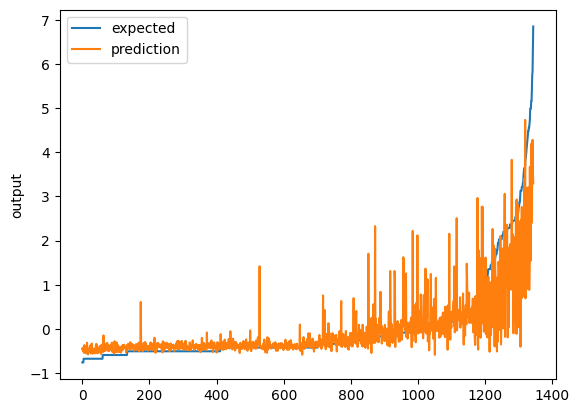

In [ ]:
y_test_np = np.array(y_test)

#chart_regression(pred_lstm.flatten(),y_test_np,sort=False)
chart_regression(pred_lstm.flatten(),y_test_np)

### FINDING EFFICIENT N FOR LSTM MODEL  

In [ ]:

temp_rmse = 10000000.00000000

for SEQUENCE_SIZE in range(6,15):

  X,Y = to_sequences(SEQUENCE_SIZE,xn1,'Appliances')
  bx_train, bx_test, by_train, by_test = train_test_split(X, Y, test_size=0.30, random_state=42)

  print("Shape of x_train: {}".format(bx_train.shape))
  print("Shape of x_test: {}".format(bx_test.shape))
  print("Shape of y_train: {}".format(by_train.shape))
  print("Shape of y_test: {}".format(by_test.shape))

  from keras.layers import LSTM

  checkpointer = ModelCheckpoint(filepath="/content/best_weights_lstm2222.hdf5", verbose=0, save_best_only=True) # save best model


  blmodel = Sequential()
  # Build network
  blmodel.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 10), return_sequences=True))
  blmodel.add(LSTM(64, return_sequences=False))
  blmodel.add(Dense(32))
  blmodel.add(Dense(1))


  blmodel.compile(loss='mean_squared_error', optimizer='adam')

  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

  blmodel.fit(bx_train,by_train,validation_data=(bx_test,by_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

  print('Training finished...Loading the best model')
  print()
  blmodel.load_weights("/content/best_weights_lstm2222.hdf5") # load weights from best model

  from sklearn import metrics

  # Predict
  pred_lstmm = blmodel.predict(bx_test)

  # Measure MSE error.
  score = metrics.mean_squared_error(pred_lstmm,by_test)
  print("Final score (MSE): {}".format(score))

  # Measure RMSE error.  RMSE is common for regression.
  score = np.sqrt(metrics.mean_squared_error(pred_lstmm,by_test))
  print("Final score (RMSE): {}".format(score))

  if score < temp_rmse:
    temp_rmse = score
    Final_seq = SEQUENCE_SIZE
    print("current best rmse:",temp_rmse)
    print("current best sequence number:",Final_seq)
  else:
    print("current best rmse:",temp_rmse)
    print("current best sequence number:",Final_seq)

print("Final RMSE:",temp_rmse)
print("Optimal Sequence Number:",Final_seq)

Shape of x_train: (3133, 6, 10)
Shape of x_test: (1344, 6, 10)
Shape of y_train: (3133,)
Shape of y_test: (1344,)
Epoch 1/100
98/98 - 9s - loss: 0.6608 - val_loss: 0.5757 - 9s/epoch - 94ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 - 3s - loss: 0.4589 - val_loss: 0.4343 - 3s/epoch - 28ms/step
Epoch 3/100
98/98 - 3s - loss: 0.4394 - val_loss: 0.4166 - 3s/epoch - 27ms/step
Epoch 4/100
98/98 - 4s - loss: 0.4163 - val_loss: 0.4009 - 4s/epoch - 38ms/step
Epoch 5/100
98/98 - 3s - loss: 0.4291 - val_loss: 0.4369 - 3s/epoch - 29ms/step
Epoch 6/100
98/98 - 3s - loss: 0.4166 - val_loss: 0.4147 - 3s/epoch - 27ms/step
Epoch 7/100
98/98 - 3s - loss: 0.3942 - val_loss: 0.4023 - 3s/epoch - 29ms/step
Epoch 8/100
98/98 - 4s - loss: 0.3690 - val_loss: 0.3995 - 4s/epoch - 37ms/step
Epoch 9/100
98/98 - 3s - loss: 0.4149 - val_loss: 0.4038 - 3s/epoch - 31ms/step
Epoch 10/100
98/98 - 3s - loss: 0.3695 - val_loss: 0.4045 - 3s/epoch - 26ms/step
Epoch 11/100
98/98 - 3s - loss: 0.4021 - val_loss: 0.4087 - 3s/epoch - 27ms/step
Epoch 12/100
98/98 - 3s - loss: 0.3758 - val_loss: 0.4114 - 3s/epoch - 35ms/step
Epoch 13/100
98/98 - 3s - loss: 0.3787 - val_loss: 0.3933 - 3s/epoch - 30ms/step
Epoch 14/100
98/98 - 3s - loss: 0.3832 - val_los

Shape of x_train: (3133, 7, 10)
Shape of x_test: (1343, 7, 10)
Shape of y_train: (3133,)
Shape of y_test: (1343,)
Epoch 1/100
98/98 - 10s - loss: 0.7073 - val_loss: 0.5433 - 10s/epoch - 99ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 - 4s - loss: 0.5036 - val_loss: 0.4188 - 4s/epoch - 41ms/step
Epoch 3/100
98/98 - 3s - loss: 0.4495 - val_loss: 0.4148 - 3s/epoch - 31ms/step
Epoch 4/100
98/98 - 3s - loss: 0.4108 - val_loss: 0.3810 - 3s/epoch - 31ms/step
Epoch 5/100
98/98 - 3s - loss: 0.4377 - val_loss: 0.3890 - 3s/epoch - 30ms/step
Epoch 6/100
98/98 - 4s - loss: 0.4242 - val_loss: 0.3744 - 4s/epoch - 41ms/step
Epoch 7/100
98/98 - 3s - loss: 0.4088 - val_loss: 0.3623 - 3s/epoch - 30ms/step
Epoch 8/100
98/98 - 3s - loss: 0.4126 - val_loss: 0.3590 - 3s/epoch - 30ms/step
Epoch 9/100
98/98 - 3s - loss: 0.4186 - val_loss: 0.3719 - 3s/epoch - 29ms/step
Epoch 10/100
98/98 - 4s - loss: 0.3880 - val_loss: 0.3637 - 4s/epoch - 41ms/step
Epoch 11/100
98/98 - 3s - loss: 0.3941 - val_loss: 0.3625 - 3s/epoch - 30ms/step
Epoch 12/100
98/98 - 3s - loss: 0.3832 - val_loss: 0.3805 - 3s/epoch - 30ms/step
Epoch 13/100
98/98 - 3s - loss: 0.3897 - val_loss: 0.3644 - 3s/epoch - 31ms/step
Epoch 13: early stopping
Training finished...Loa

Shape of x_train: (3132, 8, 10)
Shape of x_test: (1343, 8, 10)
Shape of y_train: (3132,)
Shape of y_test: (1343,)
Epoch 1/100
98/98 - 10s - loss: 0.7166 - val_loss: 0.6199 - 10s/epoch - 97ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 - 3s - loss: 0.5372 - val_loss: 0.4189 - 3s/epoch - 34ms/step
Epoch 3/100
98/98 - 4s - loss: 0.4667 - val_loss: 0.4050 - 4s/epoch - 45ms/step
Epoch 4/100
98/98 - 3s - loss: 0.4600 - val_loss: 0.3645 - 3s/epoch - 35ms/step
Epoch 5/100
98/98 - 3s - loss: 0.4258 - val_loss: 0.3752 - 3s/epoch - 33ms/step
Epoch 6/100
98/98 - 4s - loss: 0.4218 - val_loss: 0.3469 - 4s/epoch - 44ms/step
Epoch 7/100
98/98 - 4s - loss: 0.4380 - val_loss: 0.3522 - 4s/epoch - 38ms/step
Epoch 8/100
98/98 - 3s - loss: 0.4258 - val_loss: 0.3317 - 3s/epoch - 33ms/step
Epoch 9/100
98/98 - 3s - loss: 0.4206 - val_loss: 0.3505 - 3s/epoch - 34ms/step
Epoch 10/100
98/98 - 4s - loss: 0.4021 - val_loss: 0.3734 - 4s/epoch - 44ms/step
Epoch 11/100
98/98 - 3s - loss: 0.4022 - val_loss: 0.3807 - 3s/epoch - 31ms/step
Epoch 12/100
98/98 - 3s - loss: 0.4058 - val_loss: 0.3441 - 3s/epoch - 33ms/step
Epoch 13/100
98/98 - 4s - loss: 0.3786 - val_loss: 0.3605 - 4s/epoch - 42ms/step
Epoch 13: early stopping
Training finished...Loa

Shape of x_train: (3131, 9, 10)
Shape of x_test: (1343, 9, 10)
Shape of y_train: (3131,)
Shape of y_test: (1343,)
Epoch 1/100
98/98 - 10s - loss: 0.7042 - val_loss: 0.5956 - 10s/epoch - 99ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 - 4s - loss: 0.5087 - val_loss: 0.4611 - 4s/epoch - 37ms/step
Epoch 3/100
98/98 - 4s - loss: 0.4378 - val_loss: 0.4318 - 4s/epoch - 37ms/step
Epoch 4/100
98/98 - 5s - loss: 0.4191 - val_loss: 0.3856 - 5s/epoch - 49ms/step
Epoch 5/100
98/98 - 4s - loss: 0.4214 - val_loss: 0.3833 - 4s/epoch - 37ms/step
Epoch 6/100
98/98 - 4s - loss: 0.4120 - val_loss: 0.3829 - 4s/epoch - 37ms/step
Epoch 7/100
98/98 - 5s - loss: 0.3906 - val_loss: 0.4021 - 5s/epoch - 47ms/step
Epoch 8/100
98/98 - 3s - loss: 0.3953 - val_loss: 0.3833 - 3s/epoch - 35ms/step
Epoch 9/100
98/98 - 4s - loss: 0.3920 - val_loss: 0.3837 - 4s/epoch - 38ms/step
Epoch 10/100
98/98 - 4s - loss: 0.3797 - val_loss: 0.3769 - 4s/epoch - 42ms/step
Epoch 11/100
98/98 - 4s - loss: 0.3743 - val_loss: 0.3906 - 4s/epoch - 40ms/step
Epoch 12/100
98/98 - 4s - loss: 0.3590 - val_loss: 0.3802 - 4s/epoch - 36ms/step
Epoch 13/100
98/98 - 4s - loss: 0.3672 - val_loss: 0.4348 - 4s/epoch - 36ms/step
Epoch 14/100
98/98 - 5s - loss: 0.3630 - val_los

Shape of x_train: (3131, 10, 10)
Shape of x_test: (1342, 10, 10)
Shape of y_train: (3131,)
Shape of y_test: (1342,)
Epoch 1/100
98/98 - 9s - loss: 0.7172 - val_loss: 0.6027 - 9s/epoch - 93ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 - 5s - loss: 0.4924 - val_loss: 0.4337 - 5s/epoch - 52ms/step
Epoch 3/100
98/98 - 4s - loss: 0.4200 - val_loss: 0.4237 - 4s/epoch - 41ms/step
Epoch 4/100
98/98 - 4s - loss: 0.4521 - val_loss: 0.4421 - 4s/epoch - 39ms/step
Epoch 5/100
98/98 - 5s - loss: 0.4155 - val_loss: 0.4144 - 5s/epoch - 52ms/step
Epoch 6/100
98/98 - 4s - loss: 0.3919 - val_loss: 0.4165 - 4s/epoch - 40ms/step
Epoch 7/100
98/98 - 4s - loss: 0.3945 - val_loss: 0.4048 - 4s/epoch - 43ms/step
Epoch 8/100
98/98 - 5s - loss: 0.3795 - val_loss: 0.4039 - 5s/epoch - 51ms/step
Epoch 9/100
98/98 - 4s - loss: 0.3743 - val_loss: 0.3966 - 4s/epoch - 40ms/step
Epoch 10/100
98/98 - 4s - loss: 0.3545 - val_loss: 0.4315 - 4s/epoch - 42ms/step
Epoch 11/100
98/98 - 5s - loss: 0.3768 - val_loss: 0.3998 - 5s/epoch - 47ms/step
Epoch 12/100
98/98 - 4s - loss: 0.3600 - val_loss: 0.3881 - 4s/epoch - 40ms/step
Epoch 13/100
98/98 - 5s - loss: 0.3395 - val_loss: 0.3931 - 5s/epoch - 48ms/step
Epoch 14/100
98/98 - 4s - loss: 0.3405 - val_los

Shape of x_train: (3130, 11, 10)
Shape of x_test: (1342, 11, 10)
Shape of y_train: (3130,)
Shape of y_test: (1342,)
Epoch 1/100
98/98 - 11s - loss: 0.7053 - val_loss: 0.6578 - 11s/epoch - 110ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 - 5s - loss: 0.5054 - val_loss: 0.4872 - 5s/epoch - 56ms/step
Epoch 3/100
98/98 - 5s - loss: 0.4397 - val_loss: 0.4652 - 5s/epoch - 47ms/step
Epoch 4/100
98/98 - 4s - loss: 0.4170 - val_loss: 0.4530 - 4s/epoch - 45ms/step
Epoch 5/100
98/98 - 6s - loss: 0.3909 - val_loss: 0.4399 - 6s/epoch - 57ms/step
Epoch 6/100
98/98 - 4s - loss: 0.3733 - val_loss: 0.4295 - 4s/epoch - 45ms/step
Epoch 7/100
98/98 - 6s - loss: 0.3848 - val_loss: 0.4515 - 6s/epoch - 57ms/step
Epoch 8/100
98/98 - 4s - loss: 0.3999 - val_loss: 0.4264 - 4s/epoch - 45ms/step
Epoch 9/100
98/98 - 4s - loss: 0.3716 - val_loss: 0.4308 - 4s/epoch - 44ms/step
Epoch 10/100
98/98 - 6s - loss: 0.3595 - val_loss: 0.4193 - 6s/epoch - 56ms/step
Epoch 11/100
98/98 - 4s - loss: 0.3654 - val_loss: 0.4530 - 4s/epoch - 44ms/step
Epoch 12/100
98/98 - 5s - loss: 0.3730 - val_loss: 0.4337 - 5s/epoch - 55ms/step
Epoch 13/100
98/98 - 4s - loss: 0.3402 - val_loss: 0.4423 - 4s/epoch - 45ms/step
Epoch 14/100
98/98 - 4s - loss: 0.3298 - val_los

Shape of x_train: (3129, 12, 10)
Shape of x_test: (1342, 12, 10)
Shape of y_train: (3129,)
Shape of y_test: (1342,)
Epoch 1/100
98/98 - 12s - loss: 0.7248 - val_loss: 0.5532 - 12s/epoch - 120ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 - 5s - loss: 0.5056 - val_loss: 0.4037 - 5s/epoch - 49ms/step
Epoch 3/100
98/98 - 6s - loss: 0.4451 - val_loss: 0.3765 - 6s/epoch - 63ms/step
Epoch 4/100
98/98 - 5s - loss: 0.4139 - val_loss: 0.3789 - 5s/epoch - 48ms/step
Epoch 5/100
98/98 - 5s - loss: 0.4341 - val_loss: 0.3664 - 5s/epoch - 48ms/step
Epoch 6/100
98/98 - 5s - loss: 0.4115 - val_loss: 0.3878 - 5s/epoch - 56ms/step
Epoch 7/100
98/98 - 5s - loss: 0.4193 - val_loss: 0.3428 - 5s/epoch - 49ms/step
Epoch 8/100
98/98 - 6s - loss: 0.4164 - val_loss: 0.3662 - 6s/epoch - 58ms/step
Epoch 9/100
98/98 - 5s - loss: 0.4094 - val_loss: 0.3501 - 5s/epoch - 48ms/step
Epoch 10/100
98/98 - 6s - loss: 0.3783 - val_loss: 0.3528 - 6s/epoch - 57ms/step
Epoch 11/100
98/98 - 5s - loss: 0.3740 - val_loss: 0.3701 - 5s/epoch - 48ms/step
Epoch 12/100
98/98 - 5s - loss: 0.3730 - val_loss: 0.3711 - 5s/epoch - 49ms/step
Epoch 12: early stopping
Training finished...Loading the best model

42/42 [==============================] - 1s 9ms/step
Final s

Shape of x_train: (3129, 13, 10)
Shape of x_test: (1341, 13, 10)
Shape of y_train: (3129,)
Shape of y_test: (1341,)
Epoch 1/100
98/98 - 12s - loss: 0.6882 - val_loss: 0.6137 - 12s/epoch - 118ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 - 5s - loss: 0.5208 - val_loss: 0.4183 - 5s/epoch - 53ms/step
Epoch 3/100
98/98 - 6s - loss: 0.4481 - val_loss: 0.4113 - 6s/epoch - 62ms/step
Epoch 4/100
98/98 - 5s - loss: 0.4185 - val_loss: 0.3925 - 5s/epoch - 52ms/step
Epoch 5/100
98/98 - 6s - loss: 0.4377 - val_loss: 0.3749 - 6s/epoch - 59ms/step
Epoch 6/100
98/98 - 5s - loss: 0.4140 - val_loss: 0.3681 - 5s/epoch - 54ms/step
Epoch 7/100
98/98 - 5s - loss: 0.3896 - val_loss: 0.3736 - 5s/epoch - 50ms/step
Epoch 8/100
98/98 - 6s - loss: 0.4076 - val_loss: 0.3919 - 6s/epoch - 61ms/step
Epoch 9/100
98/98 - 5s - loss: 0.4000 - val_loss: 0.3680 - 5s/epoch - 51ms/step
Epoch 10/100
98/98 - 6s - loss: 0.3792 - val_loss: 0.3583 - 6s/epoch - 63ms/step
Epoch 11/100
98/98 - 5s - loss: 0.3870 - val_loss: 0.3572 - 5s/epoch - 54ms/step
Epoch 12/100
98/98 - 6s - loss: 0.3878 - val_loss: 0.3531 - 6s/epoch - 62ms/step
Epoch 13/100
98/98 - 5s - loss: 0.3690 - val_loss: 0.3444 - 5s/epoch - 53ms/step
Epoch 14/100
98/98 - 6s - loss: 0.3495 - val_los

Shape of x_train: (3128, 14, 10)
Shape of x_test: (1341, 14, 10)
Shape of y_train: (3128,)
Shape of y_test: (1341,)
Epoch 1/100
98/98 - 10s - loss: 0.6801 - val_loss: 0.6564 - 10s/epoch - 106ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 - 6s - loss: 0.5161 - val_loss: 0.4826 - 6s/epoch - 65ms/step
Epoch 3/100
98/98 - 5s - loss: 0.4391 - val_loss: 0.4396 - 5s/epoch - 53ms/step
Epoch 4/100
98/98 - 6s - loss: 0.3975 - val_loss: 0.4285 - 6s/epoch - 66ms/step
Epoch 5/100
98/98 - 5s - loss: 0.3844 - val_loss: 0.4156 - 5s/epoch - 55ms/step
Epoch 6/100
98/98 - 6s - loss: 0.4027 - val_loss: 0.4219 - 6s/epoch - 65ms/step
Epoch 7/100
98/98 - 5s - loss: 0.3583 - val_loss: 0.4372 - 5s/epoch - 52ms/step
Epoch 8/100
98/98 - 6s - loss: 0.3726 - val_loss: 0.4355 - 6s/epoch - 65ms/step
Epoch 9/100
98/98 - 5s - loss: 0.3737 - val_loss: 0.4100 - 5s/epoch - 53ms/step
Epoch 10/100
98/98 - 7s - loss: 0.3766 - val_loss: 0.4227 - 7s/epoch - 71ms/step
Epoch 11/100
98/98 - 5s - loss: 0.3540 - val_loss: 0.4108 - 5s/epoch - 54ms/step
Epoch 12/100
98/98 - 6s - loss: 0.3447 - val_loss: 0.4246 - 6s/epoch - 65ms/step
Epoch 13/100
98/98 - 5s - loss: 0.3437 - val_loss: 0.4015 - 5s/epoch - 56ms/step
Epoch 14/100
98/98 - 6s - loss: 0.3430 - val_los

##USING Sequance number: 13

In [ ]:
SEQUENCE_SIZE = 13
X,Y = to_sequences(SEQUENCE_SIZE,xn1,'Appliances')
bbx_train, bbx_test, bby_train, bby_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [ ]:
bbx_train.shape

(3129, 13, 10)

In [ ]:
!rm -rf ./logs/  # remove any previous tensorboard logs
from keras.layers import LSTM

checkpointer = ModelCheckpoint(filepath="/content/best_weights_llstmmmm.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)
    bmodell = Sequential()
    # Build network
    bmodell.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1, input_shape=(SEQUENCE_SIZE, 10), return_sequences=True))
    bmodell.add(LSTM(64, return_sequences=False))
    bmodell.add(Dense(32))
    bmodell.add(Dense(1))

    bmodell.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

    #tensorboard
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    bmodell.fit(bbx_train,bby_train,validation_data=(bbx_test,bby_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

print('Training finished...Loading the best model')
print()
bmodell.load_weights("/content/best_weights_llstmmmm.hdf5") # load weights from best model

0
Epoch 1/100
98/98 - 11s - loss: 0.7203 - val_loss: 0.5963 - 11s/epoch - 111ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 - 6s - loss: 0.5368 - val_loss: 0.4692 - 6s/epoch - 58ms/step
Epoch 3/100
98/98 - 6s - loss: 0.4647 - val_loss: 0.3889 - 6s/epoch - 66ms/step
Epoch 4/100
98/98 - 8s - loss: 0.4430 - val_loss: 0.3930 - 8s/epoch - 78ms/step
Epoch 5/100
98/98 - 6s - loss: 0.4073 - val_loss: 0.3560 - 6s/epoch - 66ms/step
Epoch 6/100
98/98 - 5s - loss: 0.4086 - val_loss: 0.3697 - 5s/epoch - 50ms/step
Epoch 7/100
98/98 - 6s - loss: 0.4059 - val_loss: 0.3652 - 6s/epoch - 62ms/step
Epoch 8/100
98/98 - 5s - loss: 0.3990 - val_loss: 0.3510 - 5s/epoch - 52ms/step
Epoch 9/100
98/98 - 6s - loss: 0.4090 - val_loss: 0.3524 - 6s/epoch - 62ms/step
Epoch 10/100
98/98 - 5s - loss: 0.3988 - val_loss: 0.3640 - 5s/epoch - 50ms/step
Epoch 11/100
98/98 - 6s - loss: 0.3687 - val_loss: 0.3654 - 6s/epoch - 62ms/step
Epoch 12/100
98/98 - 5s - loss: 0.3834 - val_loss: 0.3520 - 5s/epoch - 52ms/step
Epoch 13/100
98/98 - 5s - loss: 0.3761 - val_loss: 0.3684 - 5s/epoch - 51ms/step
Epoch 13: early stopping


1
Epoch 1/100
98/98 - 10s - loss: 0.7080 - val_loss: 0.5964 - 10s/epoch - 106ms/step
Epoch 2/100
98/98 - 6s - loss: 0.5115 - val_loss: 0.4325 - 6s/epoch - 62ms/step
Epoch 3/100
98/98 - 6s - loss: 0.4561 - val_loss: 0.4076 - 6s/epoch - 57ms/step
Epoch 4/100
98/98 - 6s - loss: 0.4350 - val_loss: 0.3845 - 6s/epoch - 66ms/step
Epoch 5/100
98/98 - 5s - loss: 0.4155 - val_loss: 0.3698 - 5s/epoch - 50ms/step
Epoch 6/100
98/98 - 6s - loss: 0.4178 - val_loss: 0.3839 - 6s/epoch - 62ms/step
Epoch 7/100
98/98 - 5s - loss: 0.3989 - val_loss: 0.3677 - 5s/epoch - 52ms/step
Epoch 8/100
98/98 - 6s - loss: 0.4104 - val_loss: 0.3730 - 6s/epoch - 62ms/step
Epoch 9/100
98/98 - 5s - loss: 0.3808 - val_loss: 0.3887 - 5s/epoch - 51ms/step
Epoch 10/100
98/98 - 5s - loss: 0.3925 - val_loss: 0.3698 - 5s/epoch - 51ms/step
Epoch 11/100
98/98 - 6s - loss: 0.3770 - val_loss: 0.3636 - 6s/epoch - 63ms/step
Epoch 12/100
98/98 - 5s - loss: 0.3809 - val_loss: 0.3673 - 5s/epoch - 50ms/step
Epoch 13/100
98/98 - 6s - loss: 

2
Epoch 1/100
98/98 - 9s - loss: 0.7552 - val_loss: 0.6466 - 9s/epoch - 97ms/step
Epoch 2/100
98/98 - 6s - loss: 0.5771 - val_loss: 0.4633 - 6s/epoch - 61ms/step
Epoch 3/100
98/98 - 5s - loss: 0.4886 - val_loss: 0.3875 - 5s/epoch - 49ms/step
Epoch 4/100
98/98 - 6s - loss: 0.4449 - val_loss: 0.3692 - 6s/epoch - 61ms/step
Epoch 5/100
98/98 - 5s - loss: 0.4104 - val_loss: 0.3934 - 5s/epoch - 48ms/step
Epoch 6/100
98/98 - 6s - loss: 0.4128 - val_loss: 0.3927 - 6s/epoch - 62ms/step
Epoch 7/100
98/98 - 5s - loss: 0.4087 - val_loss: 0.3747 - 5s/epoch - 49ms/step
Epoch 8/100
98/98 - 5s - loss: 0.3970 - val_loss: 0.3501 - 5s/epoch - 49ms/step
Epoch 9/100
98/98 - 6s - loss: 0.3871 - val_loss: 0.3550 - 6s/epoch - 60ms/step
Epoch 10/100
98/98 - 5s - loss: 0.3884 - val_loss: 0.3606 - 5s/epoch - 48ms/step
Epoch 11/100
98/98 - 6s - loss: 0.3917 - val_loss: 0.3637 - 6s/epoch - 60ms/step
Epoch 12/100
98/98 - 5s - loss: 0.3739 - val_loss: 0.3852 - 5s/epoch - 49ms/step
Epoch 13/100
98/98 - 6s - loss: 0.3

3
Epoch 1/100
98/98 - 10s - loss: 0.7111 - val_loss: 0.5947 - 10s/epoch - 101ms/step
Epoch 2/100
98/98 - 6s - loss: 0.5240 - val_loss: 0.4437 - 6s/epoch - 65ms/step
Epoch 3/100
98/98 - 5s - loss: 0.4827 - val_loss: 0.4002 - 5s/epoch - 50ms/step
Epoch 4/100
98/98 - 6s - loss: 0.4151 - val_loss: 0.4092 - 6s/epoch - 60ms/step
Epoch 5/100
98/98 - 5s - loss: 0.4451 - val_loss: 0.3627 - 5s/epoch - 52ms/step
Epoch 6/100
98/98 - 6s - loss: 0.4335 - val_loss: 0.3688 - 6s/epoch - 61ms/step
Epoch 7/100
98/98 - 5s - loss: 0.4098 - val_loss: 0.3755 - 5s/epoch - 51ms/step
Epoch 8/100
98/98 - 6s - loss: 0.3924 - val_loss: 0.3521 - 6s/epoch - 63ms/step
Epoch 9/100
98/98 - 5s - loss: 0.3751 - val_loss: 0.3523 - 5s/epoch - 51ms/step
Epoch 10/100
98/98 - 6s - loss: 0.3919 - val_loss: 0.3453 - 6s/epoch - 61ms/step
Epoch 11/100
98/98 - 5s - loss: 0.3811 - val_loss: 0.3803 - 5s/epoch - 53ms/step
Epoch 12/100
98/98 - 5s - loss: 0.3836 - val_loss: 0.3854 - 5s/epoch - 49ms/step
Epoch 13/100
98/98 - 6s - loss: 

4
Epoch 1/100
98/98 - 11s - loss: 0.7078 - val_loss: 0.5961 - 11s/epoch - 114ms/step
Epoch 2/100
98/98 - 5s - loss: 0.5070 - val_loss: 0.4298 - 5s/epoch - 51ms/step
Epoch 3/100
98/98 - 6s - loss: 0.4560 - val_loss: 0.4081 - 6s/epoch - 63ms/step
Epoch 4/100
98/98 - 5s - loss: 0.4559 - val_loss: 0.3798 - 5s/epoch - 52ms/step
Epoch 5/100
98/98 - 5s - loss: 0.4304 - val_loss: 0.3993 - 5s/epoch - 54ms/step
Epoch 6/100
98/98 - 6s - loss: 0.3883 - val_loss: 0.3617 - 6s/epoch - 58ms/step
Epoch 7/100
98/98 - 5s - loss: 0.4334 - val_loss: 0.3923 - 5s/epoch - 52ms/step
Epoch 8/100
98/98 - 6s - loss: 0.4037 - val_loss: 0.3566 - 6s/epoch - 63ms/step
Epoch 9/100
98/98 - 5s - loss: 0.3889 - val_loss: 0.3558 - 5s/epoch - 51ms/step
Epoch 10/100
98/98 - 6s - loss: 0.3898 - val_loss: 0.3769 - 6s/epoch - 61ms/step
Epoch 11/100
98/98 - 5s - loss: 0.3905 - val_loss: 0.3540 - 5s/epoch - 51ms/step
Epoch 12/100
98/98 - 6s - loss: 0.3935 - val_loss: 0.3510 - 6s/epoch - 64ms/step
Epoch 13/100
98/98 - 5s - loss: 

In [ ]:
from sklearn import metrics

# Predict
Hpred_lstm = bmodell.predict(bbx_test)

# Measure MSE error.
score = metrics.mean_squared_error(Hpred_lstm,bby_test)
print("Final score (MSE): {}".format(score))

# Measure RMSE error.
score = np.sqrt(metrics.mean_squared_error(Hpred_lstm,bby_test))
print("Final score (RMSE): {}".format(score))

42/42 [==============================] - 1s 6ms/step
Final score (MSE): 0.32566630296278154
Final score (RMSE): 0.5706717996911899


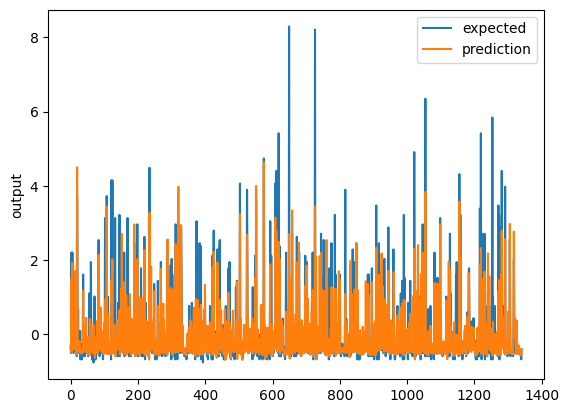

In [ ]:
y_test_npp = np.array(bby_test)

#chart_regression(pred_lstm.flatten(),y_test_np,sort=False)
chart_regression(Hpred_lstm.flatten(),y_test_npp,sort =False)

##LSTM Model With Bidirectional and Attention Layers

In [ ]:
%pip install attention


In [ ]:
from attention import Attention

In [ ]:
!rm -rf ./logs/  # remove any previous tensorboard logs
from keras.layers import LSTM

checkpointer = ModelCheckpoint(filepath="/content/Bbest_weights_llsstm.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)
    model = Sequential()
    # Build network
    model.add(Bidirectional(LSTM(128, dropout=0.1, recurrent_dropout=0.1, input_shape=(13, 10), return_sequences=True)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Attention(units=16))
    model.add(Dense(32))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

    #tensorboard
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    model.fit(bbx_train,bby_train,validation_data=(bbx_test,bby_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

print('Training finished...Loading the best model')
print()
model.load_weights("/content/Bbest_weights_llsstm.hdf5") # load weights from best model

0
Epoch 1/100
98/98 - 25s - loss: 0.5965 - val_loss: 0.4427 - 25s/epoch - 251ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 - 12s - loss: 0.4601 - val_loss: 0.4144 - 12s/epoch - 122ms/step
Epoch 3/100
98/98 - 10s - loss: 0.4245 - val_loss: 0.3835 - 10s/epoch - 98ms/step
Epoch 4/100
98/98 - 13s - loss: 0.4128 - val_loss: 0.3829 - 13s/epoch - 128ms/step
Epoch 5/100
98/98 - 11s - loss: 0.4265 - val_loss: 0.3503 - 11s/epoch - 112ms/step
Epoch 6/100
98/98 - 11s - loss: 0.3983 - val_loss: 0.3778 - 11s/epoch - 113ms/step
Epoch 7/100
98/98 - 11s - loss: 0.4032 - val_loss: 0.4478 - 11s/epoch - 117ms/step
Epoch 8/100
98/98 - 11s - loss: 0.3822 - val_loss: 0.3778 - 11s/epoch - 112ms/step
Epoch 9/100
98/98 - 11s - loss: 0.3824 - val_loss: 0.3699 - 11s/epoch - 112ms/step
Epoch 10/100
98/98 - 10s - loss: 0.3814 - val_loss: 0.3700 - 10s/epoch - 97ms/step
Epoch 10: early stopping
1
Epoch 1/100
98/98 - 24s - loss: 0.5966 - val_loss: 0.4462 - 24s/epoch - 249ms/step
Epoch 2/100
98/98 - 11s - loss: 0.4487 - val_loss: 0.3783 - 11s/epoch - 112ms/step
Epoch 3/100
98/98 - 11s - loss: 0.4281 - val_loss: 0.3928 - 11s/epoch - 1

In [ ]:
from sklearn import metrics

# Predict  bbx_test,bby_test
preddd_lstm = model.predict(bbx_test)

# Measure MSE error.
score = metrics.mean_squared_error(preddd_lstm,bby_test)
print("Final score (MSE): {}".format(score))

# Measure RMSE error.
score = np.sqrt(metrics.mean_squared_error(preddd_lstm,bby_test))
print("Final score (RMSE): {}".format(score))

42/42 [==============================] - 2s 21ms/step
Final score (MSE): 0.34264274229689323
Final score (RMSE): 0.585356935806601


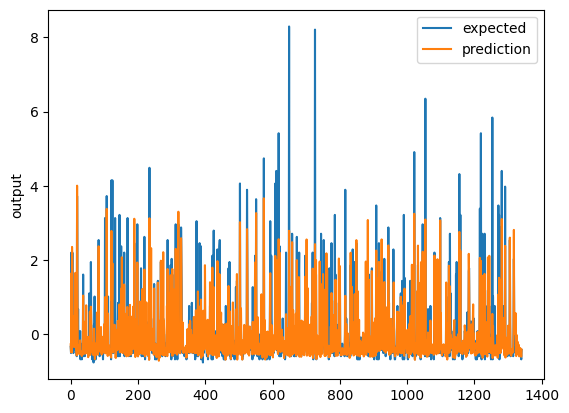

In [ ]:
yyy_test_np = np.array(bby_test)

#chart_regression(pred_lstm.flatten(),y_test_np,sort=False)
chart_regression(preddd_lstm.flatten(),yyy_test_np,sort =False)

### HYPER-PARAMETER TUNING For LSTM
SEQUENCE_SIZE = 13







In [ ]:
!rm -rf ./logs/  # remove any previous tensorboard logs
from keras.layers import LSTM

checkpointer = ModelCheckpoint(filepath="/content/Hppbbest_weights_lstm.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)
    Hpmodel = Sequential()
    # Build network
    Hpmodel.add(LSTM(100, dropout=0.1, activation='relu', input_shape=(13, 10)))
    #Hpmodel.add(LSTM(50,activation='relu', return_sequences=False))
    Hpmodel.add(Dense(25))
    Hpmodel.add(Dense(1))

    Hpmodel.compile(loss='mean_squared_error', optimizer='sgd')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

    #tensorboard
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    Hpmodel.fit(bbx_train,bby_train,validation_data=(bbx_test,bby_test),callbacks=[monitor,checkpointer],verbose=2,epochs=10)
print('Training finished...Loading the best model')
print()
Hpmodel.load_weights("/content/Hppbbest_weights_lstm.hdf5") # load weights from best model

0
Epoch 1/10
98/98 - 2s - loss: 0.7416 - val_loss: 0.5887 - 2s/epoch - 21ms/step
Epoch 2/10
98/98 - 1s - loss: 0.5707 - val_loss: 0.5493 - 627ms/epoch - 6ms/step
Epoch 3/10
98/98 - 1s - loss: 0.5411 - val_loss: 0.5277 - 595ms/epoch - 6ms/step
Epoch 4/10
98/98 - 1s - loss: 0.5289 - val_loss: 0.4980 - 620ms/epoch - 6ms/step
Epoch 5/10
98/98 - 1s - loss: 0.4889 - val_loss: 0.4889 - 628ms/epoch - 6ms/step
Epoch 6/10
98/98 - 1s - loss: 0.4736 - val_loss: 0.4615 - 609ms/epoch - 6ms/step
Epoch 7/10
98/98 - 1s - loss: 0.4692 - val_loss: 0.4671 - 580ms/epoch - 6ms/step
Epoch 8/10
98/98 - 1s - loss: 0.4700 - val_loss: 0.4420 - 636ms/epoch - 6ms/step
Epoch 9/10
98/98 - 1s - loss: 0.4316 - val_loss: 0.4244 - 604ms/epoch - 6ms/step
Epoch 10/10
98/98 - 1s - loss: 0.4416 - val_loss: 0.4306 - 604ms/epoch - 6ms/step
1
Epoch 1/10
98/98 - 2s - loss: 0.6837 - val_loss: 0.5864 - 2s/epoch - 17ms/step
Epoch 2/10
98/98 - 1s - loss: 0.5692 - val_loss: 0.5409 - 613ms/epoch - 6ms/step
Epoch 3/10
98/98 - 1s - los

In [ ]:
from sklearn import metrics

# Predict  bbx_test,bby_test
predddi_lstm = Hpmodel.predict(bbx_test)

# Measure MSE error.
score = metrics.mean_squared_error(predddi_lstm,bby_test)
print("Final score (MSE): {}".format(score))

# Measure RMSE error.
score = np.sqrt(metrics.mean_squared_error(predddi_lstm,bby_test))
print("Final score (RMSE): {}".format(score))

42/42 [==============================] - 0s 2ms/step
Final score (MSE): 0.42291535609316866
Final score (RMSE): 0.6503194262000549


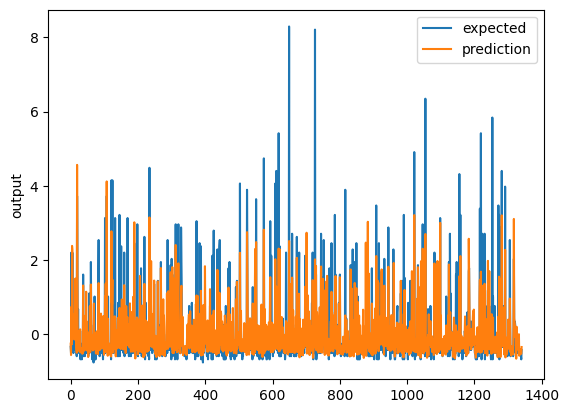

In [ ]:
yyyy_test_np = np.array(bby_test)

#chart_regression(pred_lstm.flatten(),y_test_np,sort=False)
chart_regression(predddi_lstm.flatten(),yyyy_test_np,sort =False)

# CNN MODEL

SEQUENCE_SIZE = 13, 10 colmn

In [ ]:

cnn_xtrain = bbx_train.reshape(bbx_train.shape[0], 13, 10, 1)
cnn_xtest = bbx_test.reshape(bbx_test.shape[0], 13, 10, 1)


In [ ]:
print(cnn_xtrain.shape)
print(cnn_xtest.shape)

(3129, 13, 10, 1)
(1341, 13, 10, 1)


In [ ]:
#cnn_xtrain = x_trainn.reshape(x_trainn.shape[0], 6, 10, 1)
#cnn_xtest = x_testt.reshape(x_testt.shape[0], 6, 10, 1)
#print(cnn_xtrain.shape)
#print(cnn_xtest.shape)


(13808, 6, 10, 1)
(5915, 6, 10, 1)


### CNN MODEL AND EVALUATING RMSE SCORE

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation


modelc = Sequential()
modelc.add(Conv2D(50,(3,3),activation='relu',strides=(1,1), input_shape = (13,10,1)))
modelc.add(Conv2D(25,(2,2), padding='same',activation='relu',strides=(1,1)))

modelc.add(MaxPooling2D(pool_size=(1,1)))
modelc.add(Dropout(0.2))
modelc.add(Flatten())
modelc.add(Dense(15,activation='relu'))
modelc.add(Dense(5))
modelc.add(Dense(1))

#modelc.summary()

checkpointer = ModelCheckpoint(filepath="/content/best_weights_cnnn.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)
    modelc.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')

    #tensorboard
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    modelc.fit(cnn_xtrain,bby_train,validation_data=(cnn_xtest,bby_test),callbacks=[monitor,checkpointer,tensorboard_callback],verbose=2,epochs=100)


modelc.load_weights("/content/best_weights_cnnn.hdf5")



0
Epoch 1/100
98/98 - 4s - loss: 0.8186 - val_loss: 0.5972 - 4s/epoch - 36ms/step
Epoch 2/100
98/98 - 1s - loss: 0.4742 - val_loss: 0.3894 - 840ms/epoch - 9ms/step
Epoch 3/100
98/98 - 1s - loss: 0.4025 - val_loss: 0.3589 - 668ms/epoch - 7ms/step
Epoch 4/100
98/98 - 1s - loss: 0.3748 - val_loss: 0.3727 - 640ms/epoch - 7ms/step
Epoch 5/100
98/98 - 1s - loss: 0.3726 - val_loss: 0.3456 - 634ms/epoch - 6ms/step
Epoch 6/100
98/98 - 1s - loss: 0.3499 - val_loss: 0.3390 - 693ms/epoch - 7ms/step
Epoch 7/100
98/98 - 1s - loss: 0.3500 - val_loss: 0.3834 - 711ms/epoch - 7ms/step
Epoch 8/100
98/98 - 1s - loss: 0.3370 - val_loss: 0.3790 - 697ms/epoch - 7ms/step
Epoch 9/100
98/98 - 1s - loss: 0.3343 - val_loss: 0.3633 - 695ms/epoch - 7ms/step
Epoch 10/100
98/98 - 1s - loss: 0.3280 - val_loss: 0.3418 - 664ms/epoch - 7ms/step
Epoch 11/100
98/98 - 1s - loss: 0.3121 - val_loss: 0.3403 - 642ms/epoch - 7ms/step
Epoch 11: early stopping
1
Epoch 1/100
98/98 - 2s - loss: 0.3205 - val_loss: 0.3471 - 2s/epoch -

In [ ]:
from sklearn import metrics

# Predict
pred_cnn = modelc.predict(cnn_xtest)

# Measure MSE error.
score = np.sqrt(metrics.mean_squared_error(bby_test,pred_cnn))
print("Final score (MSE): {}".format(score))

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred_cnn,bby_test))
print("Final score (RMSE): {}".format(score))


42/42 [==============================] - 0s 2ms/step
Final score (MSE): 0.5745435122310053
Final score (RMSE): 0.5745435122310053


In [ ]:
%tensorboard --logdir logs

### PLOT REGRESSION CHART

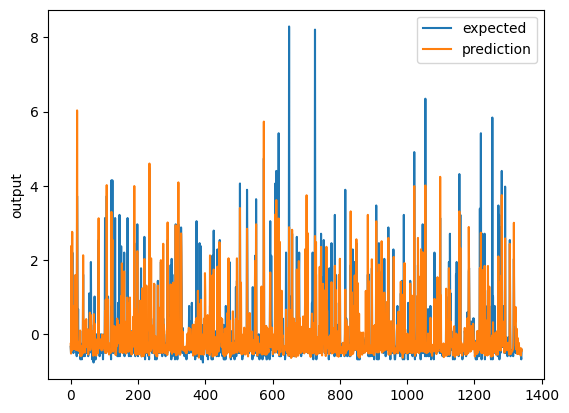

In [ ]:
yy_test_np = np.array(bby_test)

chart_regression(pred_cnn.flatten(),yy_test_np,sort=False)

#CNN HYPER-PARAMETER TUNING

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation


modelcn = Sequential()
modelcn.add(Conv2D(20,(3,3),activation='tanh',strides=(1,1), input_shape = (13,10,1)))
modelcn.add(MaxPooling2D(pool_size=(1,1)))
modelcn.add(Flatten())
modelcn.add(Dense(10,activation='tanh'))
modelcn.add(Dense(5))
modelcn.add(Dense(1))

#modelcn.summary()

checkpointer = ModelCheckpoint(filepath="/content/best_weights_cnnH.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)
    modelcn.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')

    #tensorboard
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    modelcn.fit(cnn_xtrain,bby_train,validation_data=(cnn_xtest,bby_test),callbacks=[monitor,checkpointer,tensorboard_callback],verbose=2,epochs=100)

modelcn.load_weights("/content/best_weights_cnnH.hdf5")


0
Epoch 1/100
98/98 - 1s - loss: 0.7947 - val_loss: 0.5549 - 977ms/epoch - 10ms/step
Epoch 2/100
98/98 - 0s - loss: 0.5113 - val_loss: 0.4715 - 313ms/epoch - 3ms/step
Epoch 3/100
98/98 - 0s - loss: 0.4317 - val_loss: 0.6426 - 297ms/epoch - 3ms/step
Epoch 4/100
98/98 - 0s - loss: 0.4115 - val_loss: 0.3817 - 298ms/epoch - 3ms/step
Epoch 5/100
98/98 - 0s - loss: 0.3929 - val_loss: 0.3635 - 306ms/epoch - 3ms/step
Epoch 6/100
98/98 - 0s - loss: 0.3900 - val_loss: 0.3517 - 317ms/epoch - 3ms/step
Epoch 7/100
98/98 - 0s - loss: 0.3857 - val_loss: 0.3479 - 297ms/epoch - 3ms/step
Epoch 8/100
98/98 - 0s - loss: 0.3734 - val_loss: 0.3567 - 293ms/epoch - 3ms/step
Epoch 9/100
98/98 - 0s - loss: 0.3735 - val_loss: 0.3556 - 289ms/epoch - 3ms/step
Epoch 10/100
98/98 - 0s - loss: 0.3693 - val_loss: 0.3563 - 293ms/epoch - 3ms/step
Epoch 11/100
98/98 - 0s - loss: 0.3719 - val_loss: 0.3534 - 269ms/epoch - 3ms/step
Epoch 12/100
98/98 - 0s - loss: 0.3674 - val_loss: 0.3658 - 303ms/epoch - 3ms/step
Epoch 12: 

In [ ]:

from sklearn import metrics

# Predict
pred_cnnnH = modelcn.predict(cnn_xtest)

# Measure MSE error.
score = np.sqrt(metrics.mean_squared_error(bby_test,pred_cnnnH))
print("Final score (MSE): {}".format(score))

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred_cnnnH,bby_test))
print("Final score (RMSE): {}".format(score))


42/42 [==============================] - 0s 1ms/step
Final score (MSE): 0.5748203143278787
Final score (RMSE): 0.5748203143278787


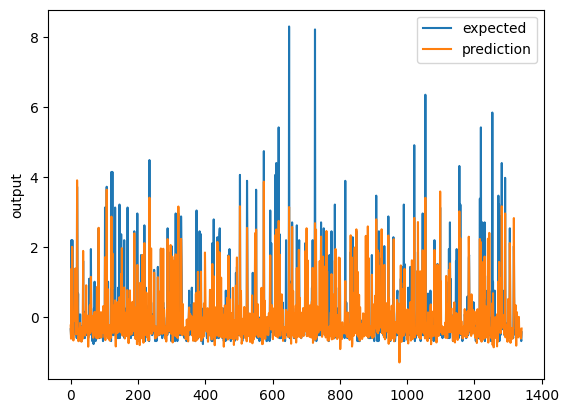

In [ ]:
y_test_npp = np.array(bby_test)

chart_regression(pred_cnnnH.flatten(),y_test_npp,sort=False)

In [ ]:
%tensorboard --logdir logs